#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [1]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [2]:
!pip install efficientnet

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"telemaco019","key":"02b9dc81900f80c86123a97b5fa5cc16"}'}

In [0]:
!rm ~/.kaggle -rf
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!cat ~/.kaggle/kaggle.json

{"username":"telemaco019","key":"02b9dc81900f80c86123a97b5fa5cc16"}

In [10]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 95% 428M/450M [00:03<00:00, 153MB/s]
100% 450M/450M [00:03<00:00, 123MB/s]


In [11]:
!unzip /content/flowers-recognition.zip 

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

# Constants and imports


In [12]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from functools import partial 
import os 
import time

import pandas as pd
import seaborn

Using TensorFlow backend.


In [13]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'
TULIP_DIR = 'tulip'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR, TULIP_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.1.0


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [17]:
(X,Y) = load_dataset()

  2%|▏         | 19/769 [00:00<00:03, 189.58it/s]

Loading data from: /content/flowers/daisy/


  3%|▎         | 35/1055 [00:00<00:02, 348.62it/s]

Loading data from: /content/flowers/dandelion/


  5%|▍         | 36/784 [00:00<00:02, 358.43it/s]

Loading data from: /content/flowers/rose/


  5%|▍         | 35/734 [00:00<00:02, 340.92it/s]

Loading data from: /content/flowers/sunflower/


  4%|▍         | 44/984 [00:00<00:02, 424.99it/s]

Loading data from: /content/flowers/tulip/


100%|██████████| 984/984 [00:02<00:00, 394.05it/s]


In [18]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 4323
Total number of labels: 4323


**Split train, valid and test datasets**

In [19]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.75)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.75)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 3242
Validation dataset size: 810
Test dataset size: 271


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs):
  STEP_SIZE_TRAIN=len(X_train)//BATCH_SIZE
  STEP_SIZE_VALID=len(X_valid)//BATCH_SIZE

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(len(X_train), STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(len(X_valid), STEP_SIZE_TRAIN))

  history = model.fit(train_dataset,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_dataset,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  start = time.time()
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  plt.figure(figsize = (10,7))
  norm_cm = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred, normalize='true')
  norm_cm_df = pd.DataFrame(norm_cm, index=encoder.classes_, columns=encoder.classes_)
  seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(Y_test)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

## Preprocessing



In [0]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [0]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [0]:
def preprocess(image, label, augmentation=False):
  if augmentation:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
    cropped_image = tf.image.random_flip_up_down(cropped_image)
    cropped_image = tf.image.random_brightness(cropped_image, max_delta=0.2)
  else:
    cropped_image = central_crop(image)
  
  resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])
  normalized_image = tf.image.per_image_standardization(resized_image)
  
  return normalized_image,label

In [0]:
def apply_cache(labeled_dataset, cache=True, batch_size=BATCH_SIZE):
  # Load the dataset once and keep it in memory.
  # Use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory (in this case a file will be used as cache).
  if isinstance(cache, str):
    labeled_dataset = labeled_dataset.cache(cache)
  else:
    labeled_dataset = labeled_dataset.cache()

  return labeled_dataset

In [0]:
def batch_and_prefetch(labeled_dataset, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE):
  return labeled_dataset.batch(batch_size).prefetch(buffer_size)

# Create Tensorflow datasets

In [0]:
unprocessed_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
unprocessed_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
unprocessed_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [0]:
cached_train_dataset = apply_cache(unprocessed_train_dataset)
cached_valid_dataset = apply_cache(unprocessed_valid_dataset)

In [35]:
test_dataset = unprocessed_test_dataset.map(partial(preprocess, augmentation=False), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE).batch(1)

valid_dataset = cached_valid_dataset.map(partial(preprocess, augmentation=False))
valid_dataset = batch_and_prefetch(valid_dataset)

train_dataset = cached_train_dataset.shuffle(buffer_size=1000).repeat().map(partial(preprocess, augmentation=True), num_parallel_calls=AUTOTUNE)
train_dataset = batch_and_prefetch(train_dataset)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


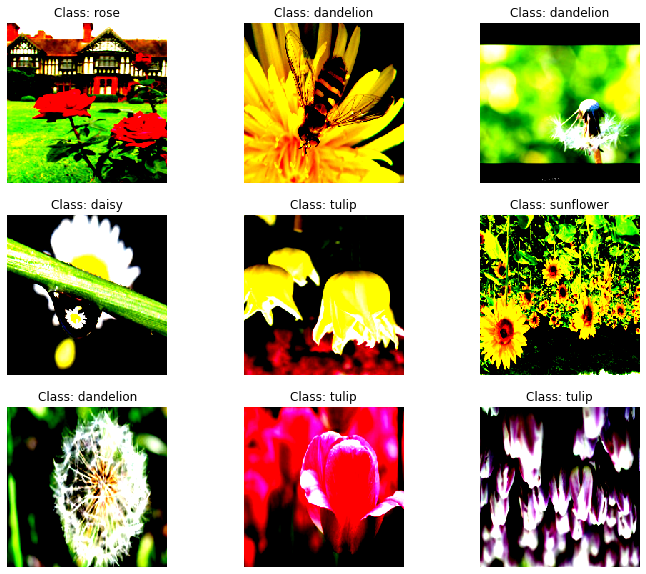

In [36]:
a, b = next(iter(train_dataset))
show_batch(a,b)

# Training from scratch

In [0]:
import efficientnet.tfkeras as efn

In [40]:
conv_base = efn.EfficientNetB4(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [47]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 5)           8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [48]:
epochs = 30
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_augmented.h5')
history = train_model(model, epochs)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/30
  1/101 [..............................] - ETA: 46:47

ResourceExhaustedError: ignored

In [0]:
plot_curves(history)
show_scores(model)

# Feature extraction with Dense hidden layer and GlobalMaxPooling

> Indented block




In [0]:
import efficientnet.tfkeras as efn

# Use layers=tf.keras.layers in order to fix Keras bug. See https://github.com/keras-team/keras/pull/9965
conv_base = efn.EfficientNetB4(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_SIZE,IMG_SIZE,3), layers=tf.keras.layers)

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

71892992/71892840 [==============================] - 6s 0us/step
Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
___________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 8,965
Non-trainable params: 17,673,816
_________________________________________________________________


In [0]:
epochs = 30
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/30
101/101 [==============================] - 37s 370ms/step - loss: 1.3946 - accuracy: 0.4703 - val_loss: 1.1840 - val_accuracy: 0.6225
Epoch 2/30
101/101 [==============================] - 19s 187ms/step - loss: 1.0624 - accuracy: 0.6937 - val_loss: 0.9387 - val_accuracy: 0.7275
Epoch 3/30
101/101 [==============================] - 19s 191ms/step - loss: 0.8902 - accuracy: 0.7500 - val_loss: 0.7998 - val_accuracy: 0.7663
Epoch 4/30
101/101 [==============================] - 19s 192ms/step - loss: 0.7771 - accuracy: 0.7871 - val_loss: 0.7087 - val_accuracy: 0.7950
Epoch 5/30
101/101 [==============================] - 19s 192ms/step - loss: 0.7069 - accuracy: 0.7989 - val_loss: 0.6463 - val_accuracy: 0.8012
Epoch 6/30
101/101 [==============================] - 19s 192ms/step - loss: 0.6538 - accuracy

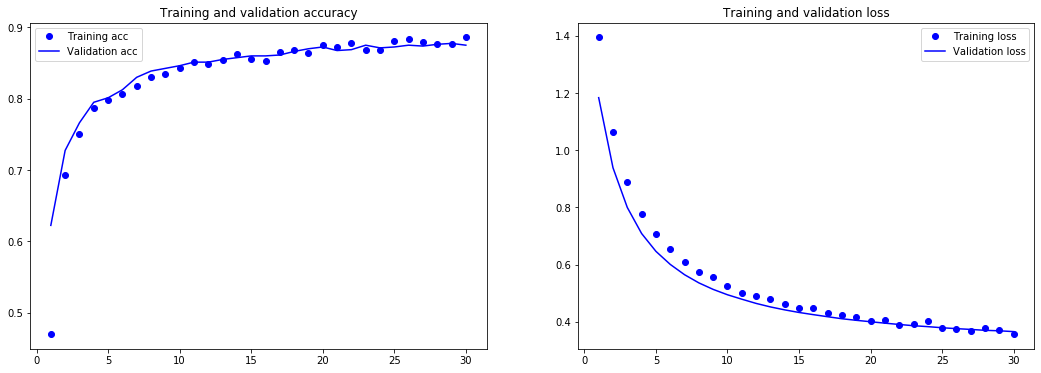

|Average prediction time: 24.23 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.89|0.89|0.89


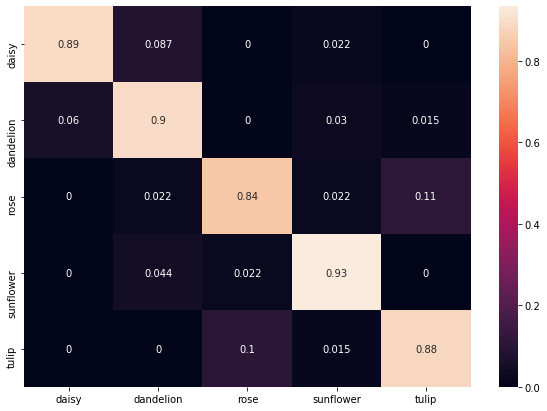

In [0]:
plot_curves(history)
show_scores(model)

# Fine tuning

In [0]:
for layer in conv_base.layers:
  if layer.name.startswith('block6') or layer.name.startswith('block7') or layer.name.startswith('top'):
    layer.trainable = True

In [0]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 13,921,597
Non-trainable params: 3,761,184
_________________________________________________________________


In [0]:
epochs = 100
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/100
101/101 [==============================] - 41s 401ms/step - loss: 0.6845 - accuracy: 0.7778 - val_loss: 0.4076 - val_accuracy: 0.8700
Epoch 2/100
101/101 [==============================] - 26s 260ms/step - loss: 0.5603 - accuracy: 0.8218 - val_loss: 0.4186 - val_accuracy: 0.8662
Epoch 3/100
101/101 [==============================] - 27s 270ms/step - loss: 0.4798 - accuracy: 0.8506 - val_loss: 0.4003 - val_accuracy: 0.8838
Epoch 4/100
101/101 [==============================] - 27s 272ms/step - loss: 0.4186 - accuracy: 0.8620 - val_loss: 0.3782 - val_accuracy: 0.8825
Epoch 5/100
101/101 [==============================] - 27s 271ms/step - loss: 0.3958 - accuracy: 0.8676 - val_loss: 0.3570 - val_accuracy: 0.8850
Epoch 6/100
101/101 [==============================] - 27s 270ms/step - loss: 0.3444 - ac

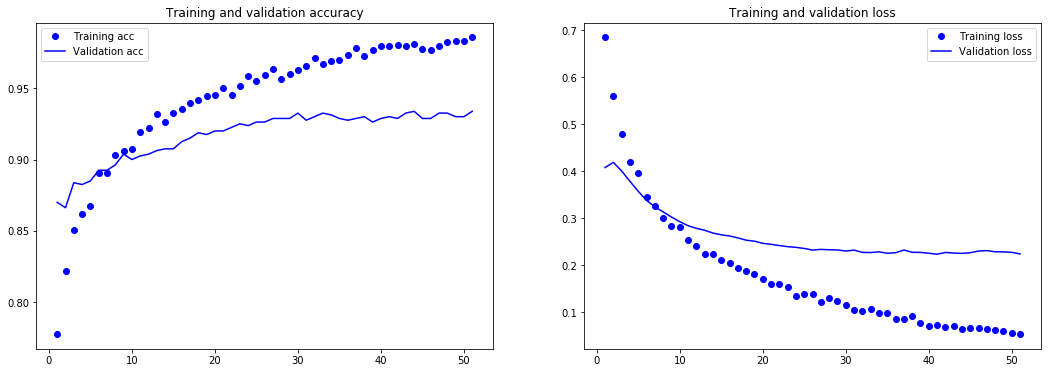

|Average prediction time: 23.65 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.92|0.92|0.92
|Macro|0.92|0.92|0.92


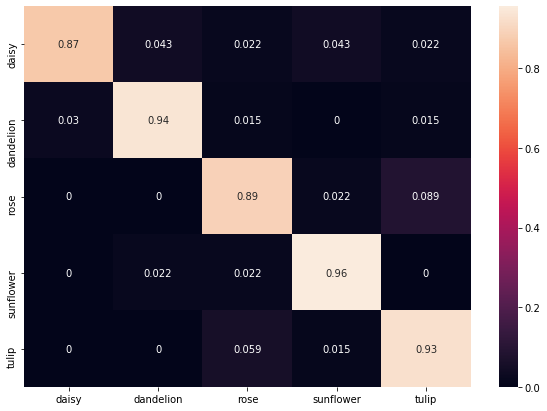

In [0]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 249 out of 271


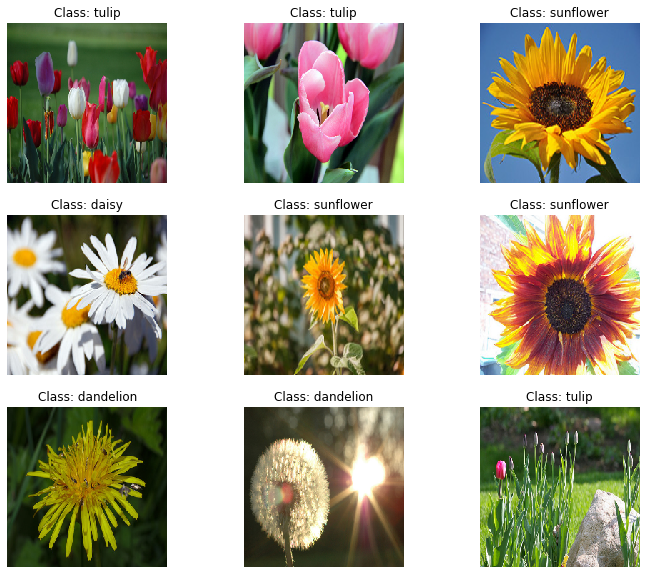

In [0]:
plot_correct_predictions(model)

Wrong predictions: 22 out of 271


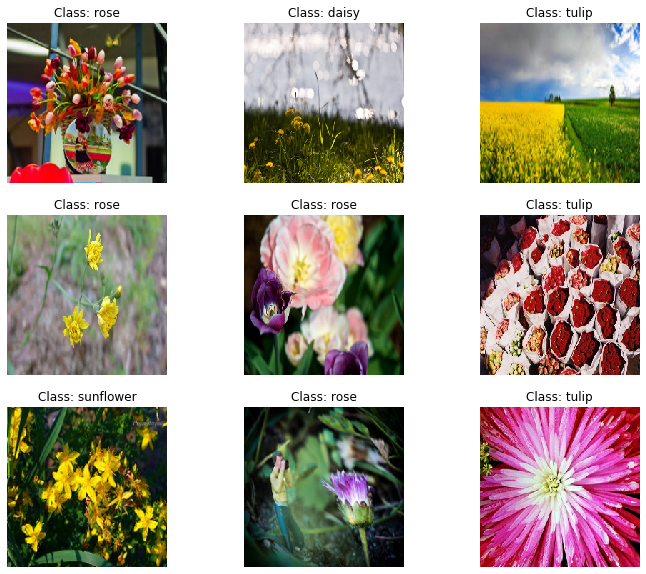

In [0]:

plot_wrong_predictions(model)